In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Machine Learning and NLP Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    mean_absolute_percentage_error
)

# Models
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR

# Sentiment Analysis (optional)
from textblob import TextBlob

In [2]:
# 1. Data Loading and Preprocessing
def load_and_preprocess_data():
    # Load News Data
    df_news = pd.read_csv('df_nyt_sample.csv', parse_dates=['date'])
    
    # Load Industrial Production Index
    indpro_path = 'https://fred.stlouisfed.org/graph/fredgraph.csv?id=INDPRO'
    df_indpro = pd.read_csv(indpro_path, parse_dates=['observation_date'])
    df_indpro.rename(columns={'observation_date': 'date', 'INDPRO': 'ipi'}, inplace=True)
    
    return df_news, df_indpro


In [3]:
# 2. Feature Engineering
def advanced_feature_extraction(df_news, df_indpro):
    # Sentiment Analysis Function
    def get_sentiment(text):
        return TextBlob(str(text)).sentiment.polarity
    
    # Preprocess and merge data
    df_news['month'] = df_news['date'].dt.to_period('M').dt.to_timestamp()
    df_indpro['month'] = df_indpro['date'].dt.to_period('M').dt.to_timestamp()
    
    # Aggregate articles by month
    df_monthly_news = df_news.groupby('month')['article'].apply(lambda x: ' '.join(x.dropna())).reset_index()
    
    # Merge with IPI
    df_merged = pd.merge(df_monthly_news, df_indpro[['month', 'ipi']], on='month')
    
    # Additional Features
    df_merged['word_count'] = df_merged['article'].apply(lambda x: len(str(x).split()))
    df_merged['sentiment_score'] = df_merged['article'].apply(get_sentiment)
    df_merged['month_num'] = df_merged['month'].dt.month
    df_merged['year'] = df_merged['month'].dt.year
    
    return df_merged

In [4]:
# 3. Text Preprocessing
def clean_text(text_input):
    text_input = str(text_input).lower()
    text_input = re.sub(r'\d+', '', text_input)
    text_input = re.sub(f"[{re.escape(string.punctuation)}]", '', text_input)
    text_input = re.sub(r'\s+', ' ', text_input).strip()
    return text_input

In [5]:
# 4. Feature Extraction
def extract_features(df_merged):
    # Topic keywords for filtering
    topic_keywords = [
        "manufacturing", "factory", "production", "industry", "output",
        "supply chain", "logistics", "transport", "shortage"
    ]
    
# Filter articles by keywords
    def filter_keywords(text, keywords):
        text = text.lower()
        return ' '.join([word for word in text.split() if any(k in word for k in keywords)])
    
    df_merged['filtered_content'] = df_merged['article'].apply(lambda x: filter_keywords(x, topic_keywords))
    
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(
        max_df=0.95,
        min_df=10,
        stop_words='english',
        token_pattern=r'\b[a-zA-Z]{3,}\b',
        preprocessor=clean_text
    )
    
    # Generate feature matrix
    X = vectorizer.fit_transform(df_merged['filtered_content'].fillna(''))
    y = df_merged['ipi'].values
    
    return X, y, vectorizer

In [6]:
# 5. Model Evaluation
def comprehensive_evaluation(y_true, y_pred):
    return {
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }

In [7]:
# 6. Visualization
def advanced_result_visualization(y_true, y_pred):
    plt.figure(figsize=(12, 6))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title('Predicted vs Actual')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    
    # Residual plot
    plt.subplot(1, 2, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals)
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Random Forest Parameters:
{'regressor__max_depth': None, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 50}
Best Score: 6.21729771707134

Ridge Model Results:
RMSE: 4.983765871069328
MAE: 2.961905237594762
R2: 0.0246245843280386
MAPE: 0.03199017456144178

Lasso Model Results:
RMSE: 5.128346753041945
MAE: 2.9690467286356066
R2: -0.03278829254203397
MAPE: 0.03215997574876969

Random Forest Model Results:
RMSE: 5.020243590346605
MAE: 2.9530106059039865
R2: 0.01029418435130336
MAPE: 0.03192145666691651

Gradient Boosting Model Results:
RMSE: 4.8817861859500296
MAE: 2.799871355053921
R2: 0.06413318070851726
MAPE: 0.030325676068147865

SVR Model Results:
RMSE: 5.091814034509319
MAE: 2.9110529410881156
R2: -0.018126189720262476
MAPE: 0.03156457063991563


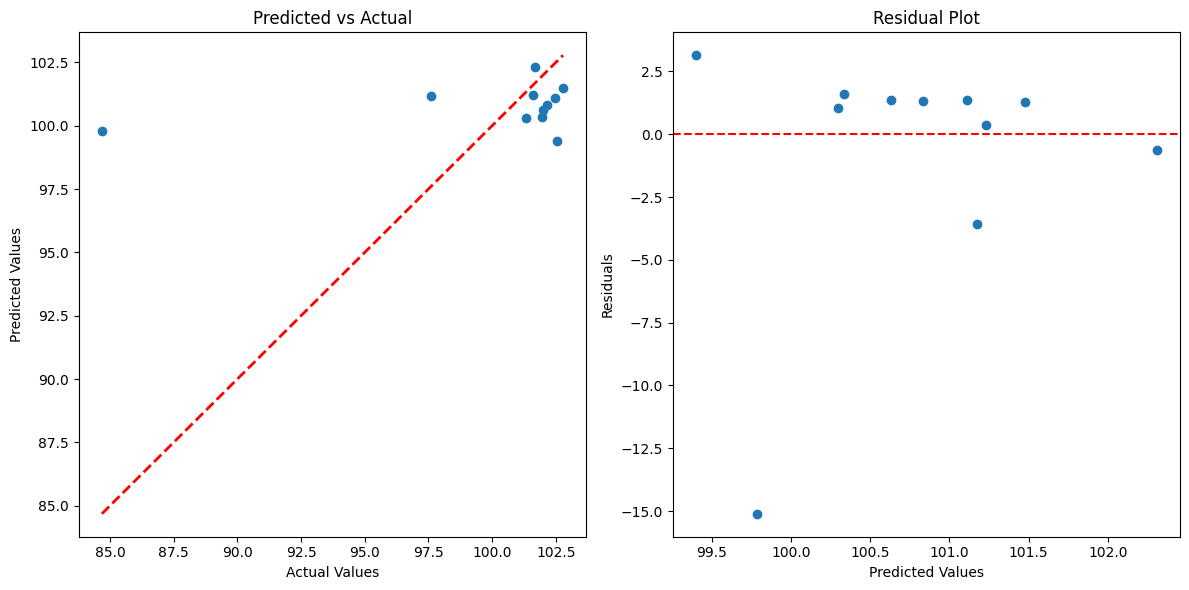

In [17]:
# 7. Main Execution
def main():
    # Load Data
    df_news, df_indpro = load_and_preprocess_data()
    
    # Feature Engineering
    df_merged = advanced_feature_extraction(df_news, df_indpro)
    
    # Extract Features
    X, y, vectorizer = extract_features(df_merged)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Define Models with Pipelines
    models = {
        "Ridge": Pipeline([
            ('scaler', StandardScaler(with_mean=False)),
            ('regressor', Ridge(alpha=1.0))
        ]),
        "Lasso": Pipeline([
            ('scaler', StandardScaler(with_mean=False)),
            ('regressor', Lasso(alpha=0.1))
        ]),
        "Random Forest": Pipeline([
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
        ]),
        "Gradient Boosting": Pipeline([
            ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
        ]),
        "SVR": Pipeline([
            ('scaler', StandardScaler(with_mean=False)),
            ('regressor', SVR(kernel='rbf', C=1.0, epsilon=0.2))
        ])
    }
    
    # Perform Grid Search for Random Forest
    rf_param_grid = {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    }
    
    # Create a separate Random Forest pipeline for grid search
    rf_pipeline = Pipeline([
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    
    grid_search = GridSearchCV(
        estimator=rf_pipeline, 
        param_grid=rf_param_grid, 
        cv=TimeSeriesSplit(n_splits=5),
        scoring='neg_mean_squared_error',
        verbose=1,
        error_score='raise'
    )
    
    grid_search.fit(X_train, y_train)
    
    # Print Grid Search Results
    print("\nBest Random Forest Parameters:")
    print(grid_search.best_params_)
    print("Best Score:", -grid_search.best_score_)
    
    # Update Random Forest model with best parameters
    best_rf_params = grid_search.best_params_
    models["Random Forest"] = Pipeline([
        ('regressor', RandomForestRegressor(
            n_estimators=best_rf_params.get('regressor__n_estimators', 100),
            max_depth=best_rf_params.get('regressor__max_depth', None),
            min_samples_split=best_rf_params.get('regressor__min_samples_split', 2),
            random_state=42
        ))
    ])
    
    # Train and Evaluate Models
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Evaluate
        print(f"\n{name} Model Results:")
        eval_metrics = comprehensive_evaluation(y_test, y_pred)
        for metric, value in eval_metrics.items():
            print(f"{metric}: {value}")
        
        results[name] = eval_metrics
    
    # Visualization
    best_model_name = min(results, key=lambda x: results[x]['RMSE'])
    best_model = models[best_model_name]
    y_pred_best = best_model.predict(X_test)
    advanced_result_visualization(y_test, y_pred_best)

# Run the script
if __name__ == "__main__":
    main()